
# TP 4: denoising

Goal: separate noise from speech signals in audio signals.

In [ ]:
%pip install torchmetrics
%pip install pesq
%pip install torchmetrics[audio]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gc
import os
import psutil
from random import randint

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torchaudio
from torchmetrics import ScaleInvariantSignalNoiseRatio
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
from torchmetrics.audio.stoi import ShortTimeObjectiveIntelligibility

from pesq import pesq

import IPython
from IPython.core.display import display
from ipywidgets import interact

## Data import

In [ ]:
try:
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)
except ImportError:
  pass


os.chdir("/content/drive/MyDrive/master/mva/signal/TP4/denoising/")

Mounted at /content/drive


In [ ]:
def load_folder(folder_path):

  if not folder_path.endswith("/"):
    folder_path += "/" 

  tensor_array, sampling_rate = [], None

  for file_name in os.listdir(folder_path):
    if file_name.endswith(".wav"):
      tensor_data, sr = torchaudio.load(folder_path + file_name)
      tensor_array.append(tensor_data)

      sampling_rate = sampling_rate or sr
      assert sampling_rate == sr, "Sampling rate not uniform on all the data"
  
  print(f"Sampling rate: {sampling_rate}")
  
  return torch.stack(tensor_array)

In [ ]:
noise_train = load_folder("noise/train/")
voice_train = load_folder("voix/train/")
noise_test = load_folder("noise/test/")
voice_test = load_folder("voix/test/")

Sampling rate: 8000
Sampling rate: 8000
Sampling rate: 8000
Sampling rate: 8000


In [ ]:
@interact
def plot_voice(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((voice_train[i]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

In [ ]:
@interact
def plot_noise(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((noise_train[i]), rate=8000))

# Pipelines

## Train and test pipelines

In [ ]:
def train(dataloader, model, loss_fn, optimizer, print_loss=True):
    size = len(dataloader.dataset)
    model.train(True)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        # pred = torch.argmax(pred, dim=1)
        loss = loss_fn(pred.squeeze(), y.squeeze())

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            if print_loss:
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      
    return loss.item()

In [ ]:
def test(dataloader, model, loss_fn, pesq_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss, pesq_err = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y.squeeze()).item()
            pesq_err += pesq_fn(pred, y.squeeze()).item()

    test_loss /= num_batches
    pesq_err /= num_batches
    
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n Avg pesq: {pesq_err:>8f}")
    
    return test_loss, pesq_err

## Results analysis

In [ ]:
def plot_performance(loss_val, loss_test, pesq_test):
    """Model performance visualization"""

    # subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Loss on validation dataset
    ax1.plot(loss_val, color='red')
    ax1.set_title("Model loss on validation set")
    ax1.set_ylabel("Loss on validation set")
    ax1.set_xlabel("Epoch")

    # Pesq on test dataset
    ax2.plot(pesq_test, color='red')
    ax2.set_title("Pesq on validation set")
    ax2.set_ylabel("Pesq on validation set")
    ax2.set_xlabel("Epoch")

    # Loss on test dataset
    ax3.plot(loss_test, color='red')
    ax3.set_title("Model loss on training set")
    ax3.set_ylabel("Loss on training set")
    ax3.set_xlabel("Epoch")

    plt.show()

Analyzing the results obtained will rely on a variety of metrics, including PESQ, STOI and ultimately; direct comparison by ear.

In [ ]:
def compare_batch(x, y, pred):
    x, y = x.squeeze(), y.squeeze()
    batch_size = y.shape[0]

    # computing the metrics
    nb_pesq = PerceptualEvaluationSpeechQuality(8000, "nb")

    x_pesq = [nb_pesq(x[i], y[i]).item() for i in range(batch_size)]
    pred_pesq = [nb_pesq(pred[i], y[i]).item() for i in range(batch_size)]

    stoi = ShortTimeObjectiveIntelligibility(8000, False)

    x_stoi = [stoi(x[i], y[i]).item() for i in range(batch_size)]
    pred_stoi = [stoi(pred[i], y[i]).item() for i in range(batch_size)]

    print(f"Mean PESQ between noisy signal and target signal:    {sum(x_pesq) / len(x_pesq):.4f}")
    print(f"Mean PESQ between denoised signal and target signal: {sum(pred_pesq) / len(pred_pesq):.4f}")

    print(f"\nMean STOI between noisy signal and target signal:    {sum(x_stoi) / len(x_stoi):.4f}")
    print(f"Mean STOI between denoised signal and target signal: {sum(pred_stoi) / len(pred_stoi):.4f}\n")

    # plotting the metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    for i in range(y.shape[0]):
      ax1.scatter(i, x_pesq[i], c='r')
      ax1.scatter(i, pred_pesq[i], c='g')

      ax2.scatter(i, x_stoi[i], c='r')
      ax2.scatter(i, pred_stoi[i], c='g')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Prediction', markerfacecolor='g', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Noisy sound', markerfacecolor='r', markersize=10)
    ]

    ax1.legend(handles=legend_elements)
    ax2.legend(handles=legend_elements)
    ax1.set(title="PESQ comparison", xlabel="Batch index", ylabel="pesq on validation set")
    ax2.set(title="STOI comparison", xlabel="Batch index", ylabel="stoi on validation set")

    plt.show()

    # direct comparison by ear
    idx = randint(0, batch_size - 1)

    print("\nYou can listen to one element in the batch (chosen randomly) using the widgets below.")
    print("\nNoisy signal\n")
    display(IPython.display.Audio(X[idx].cpu(), rate=8000))
    print("\nTarget signal\n")
    display(IPython.display.Audio(y[idx].cpu(), rate=8000))
    print("\nDenoised signal\n")
    display(IPython.display.Audio(pred[idx].cpu(), rate=8000))

## Data creation pipeline

In this part we will explore different methods for data sampling using two datasets; one containing samples of noise and another samples of voice.

### 1 to 1 voice to noise matching

In [ ]:
def one_to_one_dataset(voice_samples, noise_samples, noise_multiplier: float = 10.):
  """
  Returns:
    data, labels (data without noise)
  """
  train_set = []
  n_noise_samples = noise_samples.shape[0]
  
  for idx, voice_sample in enumerate(voice_samples):
    train_set.append(voice_sample + noise_multiplier * noise_samples[idx % n_noise_samples])
  
  return torch.stack(train_set), voice_samples

In [ ]:
train_signals, train_labels = one_to_one_dataset(voice_train, noise_train)
test_signals, test_labels = one_to_one_dataset(voice_test, noise_test)

In [ ]:
@interact
def plot_voice(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((train_signals[i]), rate=8000))
  display(IPython.display.Audio((train_labels[i]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

### Augmentation using different combinations of voice + noise

In [ ]:
def data_augmentation(voice_samples, noise_samples, noise_factor, n_noise_per_voice):
  train_set = []
  train_corr = []

  n_noise_samples = noise_samples.shape[0]

  for idx, voice_sample in enumerate(voice_samples):
    for _ in range(n_noise_per_voice):
      train_set.append(voice_sample + randint(np.min(noise_factor), np.max(noise_factor))*noise_samples[randint(0, n_noise_samples-1)])
      train_corr.append(voice_sample)

  return torch.stack(train_set), torch.stack(train_corr)

In [ ]:
train_signals, train_labels = data_augmentation(voice_train, noise_train, 10, 2)
test_signals, test_labels = data_augmentation(voice_test, noise_test, 10, 2)

In [ ]:
@interact
def plot_voice(i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> None:
  display(IPython.display.Audio((train_signals[i]), rate=8000))
  display(IPython.display.Audio((train_labels[i]), rate=8000))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), …

Due to the large amount of data generated during this phase of data augmentation, we ran across some issues because of the limit on RAM usage enforced by Google Colab.

The utilitary function below will help keep track of the memory currently allocated, and of the memory allocated for each tensor.

In [ ]:
def print_ram_usage():
  print(
      f"RAM used: {psutil.virtual_memory()[3] / 10**9} GB "
      f"({psutil.virtual_memory()[2]} %)"
  )
  

def print_tensor_size_in_memory(tensor):
  tensor_size = tensor.element_size() * tensor.nelement() / 1024 ** 2
  print(f"Tensor size in memory: {tensor_size:.4f} MB")

In [ ]:
def one_to_n_dataset(voice_samples, noise_samples, n_noise_per_voice: int, noise_factor: float = 1.):
  train_set = []

  n_noise_samples = noise_samples.shape[0]

  for idx, voice_sample in enumerate(voice_samples):
    for noise_sample in noise_samples[torch.randperm(n_noise_samples)[:n_noise_per_voice]]:
      train_set.append(voice_sample + noise_factor * noise_sample)

  return torch.stack(train_set), np.repeat(voice_samples, n_noise_per_voice)

In [ ]:
print_ram_usage()

train_signals, train_labels = one_to_n_dataset(voice_train, noise_train, 3)
test_signals, test_labels = one_to_n_dataset(voice_test, noise_test, 3)

print_ram_usage()

In [ ]:
# Freeing up some space
del noise_train, noise_test, voice_train, voice_test
gc.collect()

# Models

We came across a few issues with memory usage on Google Colab, the utilitary function below will help keep track of the memory usage on GPU.

In [ ]:
def print_mem_info() -> None:
  print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024 / 1024 :.4f} MB")
  print(f"Memory reserved:  {torch.cuda.memory_reserved(0) / 1024 / 1024 :.4f} MB")

In [ ]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_signals),
    torch.Tensor(train_labels)
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
)
test_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(test_signals),
    torch.Tensor(test_labels)
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=10,
)

In [ ]:
# Get cpu or gpu device for training.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


## ConvTasNet

In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(
        self,
        io_channels: int,
        hidden_channels: int,
        kernel_size: int,
        padding: int,
        dilation: int = 1,
    ):
        super().__init__()

        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=io_channels, out_channels=hidden_channels, kernel_size=1),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
            torch.nn.Conv1d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                groups=hidden_channels,
            ),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
        )

        self.out = torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)
        self.skip_co = torch.nn.Conv1d(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)

    def forward(self, input):
        feature = self.conv_layers(input)
        output = self.out(feature)
        skip_co = self.skip_co(feature)
        return output, skip_co

In [ ]:
class Mask(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        kernel_size: int,
        num_feats: int,
        num_hidden: int,
        num_layers: int,
        num_stacks: int,
    ):
        super().__init__()

        self.input_dim = input_dim

        self.input_norm = torch.nn.GroupNorm(num_groups=1, num_channels=input_dim, eps=1e-8)
        self.input_conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=num_feats, kernel_size=1)

        self.conv_layers = torch.nn.ModuleList([])
        for stack in range(num_stacks):
            for layer in range(num_layers):
                self.conv_layers.append(
                    ConvBlock(
                        io_channels=num_feats,
                        hidden_channels=num_hidden,
                        kernel_size=kernel_size,
                        dilation=2**layer,
                        padding=2**layer
                    )
                )
        self.output_prelu = torch.nn.PReLU()
        self.output_conv = torch.nn.Conv1d(
            in_channels=num_feats,
            out_channels=input_dim * 2,
            kernel_size=1,
        )
        self.sigmoid = torch.nn.Sigmoid()
        

    def forward(self, input):
        batch_size = input.shape[0]
        feats = self.input_norm(input)
        feats = self.input_conv(feats)
        output = 0.0
        for layer in self.conv_layers:
            residual, skip = layer(feats)
            feats = feats + residual
            output = output + skip
        output = self.output_prelu(output)
        output = self.output_conv(output)
        output = self.sigmoid(output)
        return output.view(batch_size, 2, self.input_dim, -1)

In [ ]:
class TasNet(torch.nn.Module):
    def __init__(
        self,
        enc_kernel_size: int = 16,
        enc_num_feats: int = 512,
        
        msk_kernel_size: int = 3,
        msk_num_feats: int = 128,
        msk_num_hidden_feats: int = 512,
        msk_num_layers: int = 2,
        msk_num_stacks: int = 3,
    ):
        super().__init__()

        self.enc_num_feats = enc_num_feats
        self.enc_kernel_size = enc_kernel_size
        self.enc_stride = enc_kernel_size // 2

        self.encoder = torch.nn.Conv1d(
            in_channels=1,
            out_channels=enc_num_feats,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )
        self.mask = Mask(
            input_dim=enc_num_feats,
            kernel_size=msk_kernel_size,
            num_feats=msk_num_feats,
            num_hidden=msk_num_hidden_feats,
            num_layers=msk_num_layers,
            num_stacks=msk_num_stacks
        )

        self.decoder = torch.nn.ConvTranspose1d(
            in_channels=enc_num_feats,
            out_channels=1,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )
  
    def forward(self, input):
        batch_size, num_padded_frames = input.shape[0], input.shape[2]
        feats = self.encoder(input)
        masked = self.mask(feats) * feats.unsqueeze(1)
        masked = masked.view(batch_size * 2, self.enc_num_feats, -1)
        decoded = self.decoder(masked)
        output = decoded.view(batch_size, 2, num_padded_frames)
        return output[:, 0, :]

In [ ]:
print_mem_info()

Memory allocated: 0.0000 MB
Memory reserved:  0.0000 MB


In [ ]:
def si_snr(pred, target, epsilon=1e-8):
    pred -= pred.mean()
    target -= target.mean()
    
    target_pow = target.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (pred * target).mean(axis=1, keepdim=True)
    scale = mix_pow / (target_pow + epsilon)

    target = scale * target
    error = pred - target

    target_pow = target.pow(2)
    error_pow = error.pow(2)

    target_pow = target_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    return (10 * torch.log10(target_pow) - 10 * torch.log10(error_pow)).item()

### Choice of loss function

Here we show that we did a little research.

*   https://arxiv.org/pdf/1911.08922.pdf FIR pre-emphasis filters (Perceptual transforms)
*   https://arxiv.org/pdf/1811.02508.pdf SDSDRLoss, SISDRLoss (both time domain)
*   https://arxiv.org/pdf/2010.10291.pdf RandomResolutionSTFTLoss, SumAndDifferenceSTFTLoss (both frequency domain)

\+ article on L1 loss


In [ ]:
model = TasNet().to(device)
print(model)
# loss_fn = SignalDistortionRatio().to(device)
# loss_fn = ScaleInvariantSignalDistortionRatio().to(device)
# loss_fn = ScaleInvariantSignalNoiseRatio().to(device)
# loss_fn = -ScaleInvariantSignalNoiseRatio().to(device)
# loss_fn = nn.MSELoss().to(device)
loss_fn = nn.L1Loss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

TasNet(
  (encoder): Conv1d(1, 512, kernel_size=(16,), stride=(8,), padding=(8,), bias=False)
  (mask): Mask(
    (input_norm): GroupNorm(1, 512, eps=1e-08, affine=True)
    (input_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
    (conv_layers): ModuleList(
      (0): ConvBlock(
        (conv_layers): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GroupNorm(1, 512, eps=1e-08, affine=True)
          (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
          (4): PReLU(num_parameters=1)
          (5): GroupNorm(1, 512, eps=1e-08, affine=True)
        )
        (out): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        (skip_co): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): ConvBlock(
        (conv_layers): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GroupNorm(

In [ ]:
print_mem_info()

Memory allocated: 5.4385 MB
Memory reserved:  6.0000 MB


In [ ]:
epochs = 20

loss_list_val, loss_list_test, pesq_list_test = [], [], []
test_loss = 10
val_no_impv = 0
halving = False
nb_pesq = PerceptualEvaluationSpeechQuality(8000, 'nb')

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    
    loss_test = train(train_dataloader, model, loss_fn, optimizer)
    prev_test_loss = test_loss
    test_loss, pesq_err = test(test_dataloader, model, loss_fn, nb_pesq)

    loss_list_val.append(test_loss)
    loss_list_test.append(loss_test)
    pesq_list_test.append(pesq_err)
    
    if test_loss >= prev_test_loss:
        val_no_impv += 1
        if val_no_impv >= 3:
            halving = True
        if val_no_impv >= 10:
            print("No imporvement for 10 epochs, early stopping.")
            break
    else:
        val_no_impv = 0
    if halving:
        optim_state = optimizer.state_dict()
        optim_state['param_groups'][0]['lr'] = \
            optim_state['param_groups'][0]['lr'] / 2.0
        optimizer.load_state_dict(optim_state)
        print('Learning rate adjusted to: {lr:.6f}'.format(
            lr = optim_state['param_groups'][0]['lr']))
        halving = False
    
print("Done!")

Epoch 1
-------------------------------
loss: 0.012994  [    0/ 2118]
loss: 0.012089  [  100/ 2118]
loss: 0.012211  [  200/ 2118]
loss: 0.012775  [  300/ 2118]
loss: 0.013709  [  400/ 2118]
loss: 0.010598  [  500/ 2118]
loss: 0.015674  [  600/ 2118]
loss: 0.010068  [  700/ 2118]
loss: 0.013917  [  800/ 2118]
loss: 0.011314  [  900/ 2118]
loss: 0.014564  [ 1000/ 2118]
loss: 0.013531  [ 1100/ 2118]
loss: 0.015261  [ 1200/ 2118]
loss: 0.011463  [ 1300/ 2118]
loss: 0.011307  [ 1400/ 2118]
loss: 0.013066  [ 1500/ 2118]
loss: 0.011072  [ 1600/ 2118]
loss: 0.010956  [ 1700/ 2118]
loss: 0.013513  [ 1800/ 2118]
loss: 0.010834  [ 1900/ 2118]
loss: 0.009656  [ 2000/ 2118]
loss: 0.012826  [ 2100/ 2118]
Test Error: 
 Avg loss: 0.013854 
 Avg pesq: 1.750832
Epoch 2
-------------------------------
loss: 0.014003  [    0/ 2118]
loss: 0.013828  [  100/ 2118]
loss: 0.008524  [  200/ 2118]
loss: 0.011277  [  300/ 2118]
loss: 0.010283  [  400/ 2118]
loss: 0.010074  [  500/ 2118]
loss: 0.014733  [  600/ 21

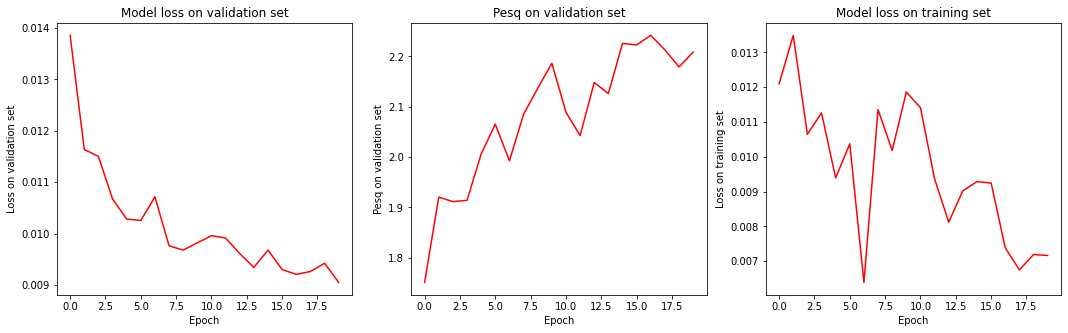

In [ ]:
plot_performance(loss_list_val, loss_list_test, pesq_list_test)

In [ ]:
with torch.no_grad():
  for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      break

Mean PESQ between noisy signal and target signal:    2.0956
Mean PESQ between denoised signal and target signal: 2.3272

Mean STOI between noisy signal and target signal:    0.8456
Mean STOI between denoised signal and target signal: 0.8567



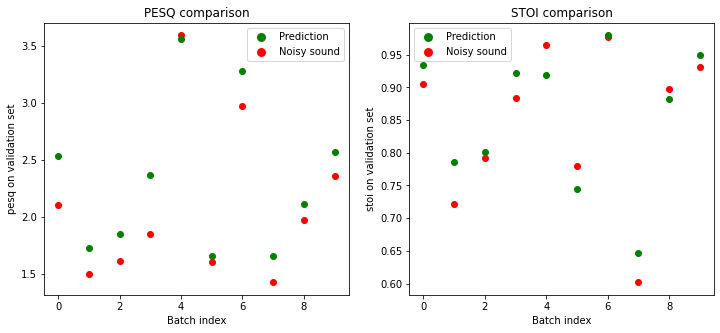


You can listen to one element in the batch (chosen randomly) using the widgets below.

Noisy signal




Target signal




Denoised signal



In [ ]:
compare_batch(X, y, pred)

## Comparison with a pretrained model

In [ ]:
%pip install asteroid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 246 kB 14.4 MB/s 
     |████████████████████████████████| 398 kB 67.4 MB/s 
     |████████████████████████████████| 800 kB 67.0 MB/s 
     |████████████████████████████████| 182 kB 80.0 MB/s 
     |████████████████████████████████| 59 kB 9.5 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 90 kB 10.6 MB/s 
     |████████████████████████████████| 41 kB 608 kB/s 
     |████████████████████████████████| 125 kB 77.9 MB/s 
  Created wheel for torch-stoi: filename=torch_stoi-0.1.2-py3-none-any.whl size=6200 sha256=009c8f7b29fecdfdbe6464094f26d122e58f28cbc6c867e6e6c869999936a920
  Stored in directory: /root/.cache/pip/wheels/55/96/76/4e46c2df4cfd5c6411d5d18bb46dd52552bdce0df460f94dc0
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21895 sha256=70382e8ad46fe80fa5b6a811bcf8d7babd00d

In [ ]:
from asteroid.models import ConvTasNet

model = ConvTasNet.from_pretrained('mpariente/ConvTasNet_WHAM!_sepclean').to(device)
print(model)
# loss_fn = SignalDistortionRatio().to(device)
# loss_fn = ScaleInvariantSignalDistortionRatio().to(device)
# loss_fn = ScaleInvariantSignalNoiseRatio().to(device)
# loss_fn = -ScaleInvariantSignalNoiseRatio().to(device)
# loss_fn = nn.MSELoss().to(device)
loss_fn = nn.L1Loss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using cached model `mpariente/ConvTasNet_WHAM!_sepclean`
ConvTasNet(
  (encoder): Encoder(
    (filterbank): FreeFB()
  )
  (masker): TDConvNet(
    (bottleneck): Sequential(
      (0): GlobLN()
      (1): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
    )
    (TCN): ModuleList(
      (0): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GlobLN()
          (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
          (4): PReLU(num_parameters=1)
          (5): GlobLN()
        )
        (res_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        (skip_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): GlobLN()
          (3): Conv1d(512, 512, kernel

In [ ]:
epochs = 20

loss_list_val, loss_list_test, pesq_list_test = [], [], []
test_loss = 10
val_no_impv = 0
halving = False
nb_pesq = PerceptualEvaluationSpeechQuality(8000, 'nb')

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    
    loss_test = train(train_dataloader, model, loss_fn, optimizer)
    prev_test_loss = test_loss
    test_loss, pesq_err = test(test_dataloader, model, loss_fn, nb_pesq)

    loss_list_val.append(test_loss)
    loss_list_test.append(loss_test)
    pesq_list_test.append(pesq_err)
    
    if test_loss >= prev_test_loss:
        val_no_impv += 1
        if val_no_impv >= 3:
            halving = True
        if val_no_impv >= 10:
            print("No imporvement for 10 epochs, early stopping.")
            break
    else:
        val_no_impv = 0
    if halving:
        optim_state = optimizer.state_dict()
        optim_state['param_groups'][0]['lr'] = \
            optim_state['param_groups'][0]['lr'] / 2.0
        optimizer.load_state_dict(optim_state)
        print('Learning rate adjusted to: {lr:.6f}'.format(
            lr = optim_state['param_groups'][0]['lr']))
        halving = False
    
print("Done!")

Epoch 1
-------------------------------


OutOfMemoryError: ignored

In [ ]:
plot_performance(loss_list_val, loss_list_test, pesq_list_test)

In [ ]:
with torch.no_grad():
  for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      break

print(pesq(8000, np.array(X[0][0].cpu()), np.array(y[0][0].cpu()), mode='nb'))
print(pesq(8000, np.array(pred[0].cpu()), np.array(y[0][0].cpu()), mode='nb'))

display(IPython.display.Audio(pred[0].cpu(), rate=8000))
display(IPython.display.Audio(X[0].cpu(), rate=8000))
display(IPython.display.Audio(y[0].cpu(), rate=8000))